In [1]:
from unsloth import FastVisionModel

model, processor = FastVisionModel.from_pretrained(
    model_name="fl_lora_s1_2d",  # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit=True,  # Set to False for 16bit LoRA
    max_seq_length=2048
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:339: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.7.9: Fast Qwen2_5_Vl patching. Transformers: 4.53.3.
   \\   /|    NVIDIA GeForce RTX 4070 Laptop GPU. Num GPUs = 1. Max memory: 7.996 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
from datasets import load_dataset

base_url = "../data_generation/dataset_s2_sm_disk/"
dataset = load_dataset(
    "arrow",
    data_files={
        "train": [base_url + "train/data-00000-of-00002.arrow", base_url + "train/data-00001-of-00002.arrow"],
        "test": base_url + "test/data-00000-of-00001.arrow"
    },
    split="train"
)

Generating train split: 160000 examples [00:00, 310533.49 examples/s]
Generating test split: 40000 examples [00:00, 376389.34 examples/s]


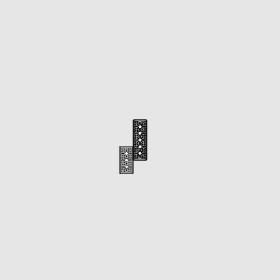

In [7]:
dataset[2]["image"]

In [8]:
dataset[2]["label"]

'[{"name": "UChannel3H", "translation": {"x": -72.0, "y": -48.0}, "rotation": 90}, {"name": "UChannel5H", "translation": {"x": 0.0, "y": 0.0}, "rotation": 270}]'

In [9]:
instruction = r"You are provided an image of a robot subsystem. Output the parts in the subsystem, as well as their spatial positions/orientations based on the reference frame (treating the middle of the image as (0, 0)) in the format of an array of JSON objects. Order the array alphabetically by the name of the components. Example Output: " \
"[[{\"name\": \"UChannel2H\", \"translation\": {\"x\": 0.0, \"y\": 48.0}, \"rotation\": 90}, {\"name\": \"UChannel4H\", \"translation\": {\"x\": 0.0, \"y\": 0.0}, \"rotation\": 90}]"

def conversation_template(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["label"]}]},
    ]
    return {"messages": conversation}

converted_dataset = [conversation_template(sample) for sample in dataset]

In [11]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

[
    {
        "name": "UChannel2H",
        "translation": {
            "x": 0.0,
            "y": 24.0
        },
        "rotation": 0
    },
    {
        "name": "UChannel4H",
        "translation": {
            "x": 0.0,
            "y": -24.0
        },
        "rotation": 0
    }
]<|im_end|>


In [12]:
import torch
from trl import SFTTrainer, SFTConfig
from unsloth.trainer import UnslothVisionDataCollator

FastVisionModel.for_training(model)  # Enable for training!
torch._dynamo.config.cache_size_limit = 32

trainer = SFTTrainer(
    model=model,
    tokenizer=processor,
    data_collator=UnslothVisionDataCollator(model, processor),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        # max_steps=30,
        num_train_epochs=1, # Set this instead of max_steps for full training runs
        learning_rate=1e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=7043,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        max_seq_length=2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [3]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4070 Laptop GPU. Max memory = 7.996 GB.
0.0 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 160,000 | Num Epochs = 1 | Total steps = 10,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 82,169,856 of 3,836,792,832 (2.14% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.913800
2,2.240900
3,1.793000
4,1.565700
5,1.049900
6,0.943500
7,0.739200
8,0.636200
9,0.502900
10,0.403900


c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\peft\utils\other.py:1221: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /unsloth/Qwen2.5-VL-3B-Instruct-unsloth-bnb-4bit/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001F233E1DFD0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 2e2e8c39-96dc-4dd4-89e5-abce17caa719)') - silently ignoring the lookup for the file config.json in unsloth/Qwen2.5-VL-3B-Instruct-unsloth-bnb-4bit.
  warnings.warn(
c:\Users\ryan\miniconda3\envs\unsloth\Lib\site-packages\peft\utils\save_and_load.py:238: UserWarning: Could not find a config file in unsloth/Qwen2.5-VL-3B-Instruct-unsloth-bnb-4bit - will assume that the vocabulary was not modified.
  warnings.warn(


In [5]:
import torch
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

NameError: name 'trainer_stats' is not defined

In [70]:
model.save_pretrained("fl_lora_s2")  # Local saving
processor.save_pretrained("fl_lora_s2")

[]

In [62]:
from unsloth import FastVisionModel

model, processor = FastVisionModel.from_pretrained(
    model_name = "fl_lora", # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = True, # Set to False for 16bit LoRA
)
FastVisionModel.for_inference(model)

image = dataset[6]["image"]

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

==((====))==  Unsloth 2025.7.9: Fast Qwen2_5_Vl patching. Transformers: 4.53.3.
   \\   /|    NVIDIA GeForce RTX 3070 Laptop GPU. Num GPUs = 1. Max memory: 8.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [66]:
FastVisionModel.for_inference(model)

image = dataset[2]["image"]

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=256,
    use_cache=True,
    temperature=1.0,
    top_p=0.95,
    top_k=64
)

[{"name": "UChannel5H", "translation": {"x": -96.0, "y": 24.0}, "rotation": 180}, {"name": "UChannel5H", "translation": {"x": 0.0, "y": 0.0}, "rotation": 90}]<|im_end|>


In [31]:
import os
import trimesh
import pyrender
import warnings
import numpy as np
from itertools import product

MODEL_DIR = "../data_generation/models_sm/"
IMG_SIZE = 512

all_xyzms = [
    v for v in product((-1, 0, 1), repeat=3)
    if v != (0, 0, 0) and sum(x != 0 for x in v) in (1, 3)
]

warnings.filterwarnings("ignore", category=UserWarning)  # ignore annoying scipy gimbal lock warnings

def load_step_part(filepath):
    mesh = trimesh.load_mesh(filepath)
    mesh.apply_translation(-mesh.centroid)
    mesh.apply_scale(1000)
    return mesh

def look_at(v_e, v_t=np.array((0, 0, 0)), up=np.array((0, 1, 0))):
    forward = v_t - v_e
    forward /= np.linalg.norm(forward)
    up = np.array([1, 0, 0]) if abs(np.dot(forward, up)) > 0.999 else up

    right = np.cross(forward, up)
    right /= np.linalg.norm(right)

    up = np.cross(right, forward)

    rot = np.eye(4)
    rot[:3, 0] = right
    rot[:3, 1] = up
    rot[:3, 2] = -forward

    trans = np.eye(4)
    trans[:3, 3] = v_e

    pose = trans @ rot
    return pose

def path_to_mesh(path):
    lines = []
    for entity in path.entities:
        segment = entity.discrete(path.vertices)
        for i in range(len(segment) - 1):
            lines.append(segment[i])
            lines.append(segment[i + 1])

    lines_np = np.array(lines, dtype=np.float32)

    line_mesh = pyrender.Primitive(
        positions=lines_np,
        mode=1,
        material=pyrender.MetallicRoughnessMaterial(
            baseColorFactor=(0.0, 0, 0),
            metallicFactor=0.8,
            roughnessFactor=0.8,
        ),
    )
    return pyrender.Mesh([line_mesh])

def render(m_transformed: list[trimesh.Trimesh], o_transformed, r: pyrender.Renderer, xyzm: tuple[int]):
    full_mesh = trimesh.Scene(m_transformed).to_geometry()
    bounds = full_mesh.bounds
    size = 2 * np.max((np.linalg.norm(bounds[1]), np.linalg.norm(bounds[0])))

    direction = xyzm
    direction = direction / np.linalg.norm(direction)

    cam_dist = size * 0.5  # adjust zoom level
    cam_position = direction * cam_dist
    cam_pose = look_at(cam_position)

    scene = pyrender.Scene(bg_color=(0.95, 0.95, 0.95, 1.0), ambient_light=[0.3, 0.3, 0.3, 1.0])

    for xyzm in all_xyzms:
        light_pose = look_at(cam_dist * np.array(xyzm, dtype=np.dtypes.Float64DType))
        light = pyrender.DirectionalLight(intensity=2.5)
        scene.add(light, pose=light_pose)

    for mesh, outline in zip(m_transformed, o_transformed):
        scene.add(
            pyrender.Mesh.from_trimesh(mesh, material=pyrender.MetallicRoughnessMaterial(
                baseColorFactor=(0.4, 0.4, 0.4, 1.0),
                metallicFactor=0.8,
                roughnessFactor=0.8,
            ), smooth=False)
        )
        scene.add(path_to_mesh(outline))

    camera = pyrender.OrthographicCamera(cam_dist, cam_dist, zfar=1000)

    scene.add(camera, pose=cam_pose)

    color, _ = r.render(scene)
    return color

In [32]:
steps = [f for f in os.listdir(MODEL_DIR) if f.lower().endswith(".step")]
meshes = [load_step_part(os.path.join(MODEL_DIR, f)) for f in steps]
outlines = []

for m in meshes:
    m = m.copy()
    m.merge_vertices()
    outlines.append(trimesh.load_path(m.vertices[m.face_adjacency_edges[m.face_adjacency_angles >= np.radians(90)]]))

r = pyrender.OffscreenRenderer(IMG_SIZE, IMG_SIZE)

In [67]:
result = [{"name": "UChannel5H", "translation": {"x": -96.0, "y": 24.0}, "rotation": 180}, {"name": "UChannel5H", "translation": {"x": 0.0, "y": 0.0}, "rotation": 90}]

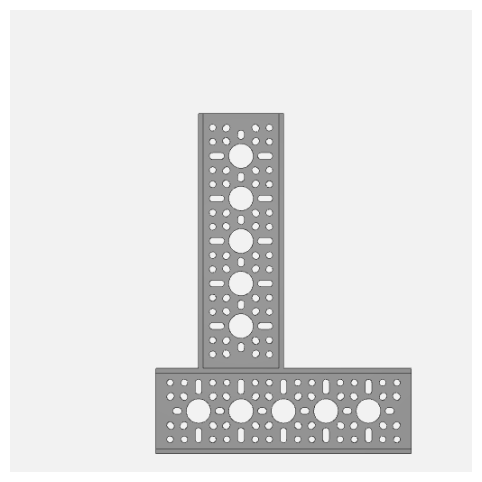

In [68]:
import matplotlib.pyplot as plt

def reconstruct(transforms):
    ms = []
    oss = []
    for t in transforms:
        idx = steps.index(t["name"] + ".STEP")
        mesh = meshes[idx].copy()
        outline = outlines[idx].copy()

        x, z = float(t["translation"]["x"]), float(t["translation"]["y"])
        mesh.apply_transform(
            trimesh.transformations.concatenate_matrices(
                trimesh.transformations.rotation_matrix(np.radians(float(t["rotation"])), (0, 1, 0)),
                trimesh.transformations.rotation_matrix(np.radians(90), (1, 0, 0))
            )
        )
        mesh.apply_translation((x, 0, z))
        
        outline.apply_transform(
            trimesh.transformations.concatenate_matrices(
                trimesh.transformations.rotation_matrix(np.radians(float(t["rotation"])), (0, 1, 0)),
                trimesh.transformations.rotation_matrix(np.radians(90), (1, 0, 0))
            )
        )
        outline.apply_translation((x, 0, z))
        
        ms.append(mesh)
        oss.append(outline)

    return render(ms, oss, r, [0, 1, 0])

plt.figure(figsize=(8, 6))
plt.axis("off")
plt.imshow(reconstruct(result))
plt.show()